2.5


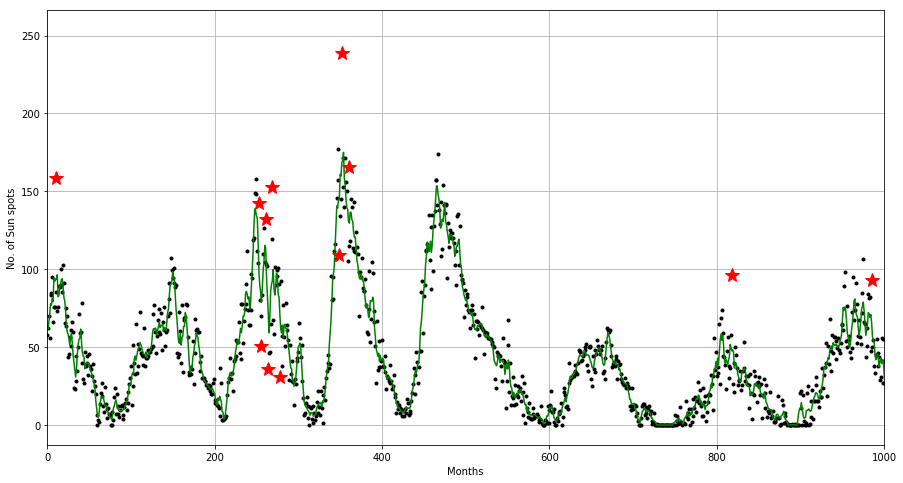

In [234]:
import re, string
from pyspark.sql.window import Window
import pyspark.sql.functions as func
import matplotlib.pyplot as plt
from pyspark.sql.types import FloatType,IntegerType

sunspots = sc.textFile('./sunspots.txt')
from pyspark.sql.functions import col,stddev

#Get month and sunspots 
sunspots_rdd = sunspots.map(lambda k: k.split("\t"))

sunspots_df = sunspots_rdd.toDF(['Months','Sunspots'])
sunspots_df = sunspots_df.withColumn("Months", sunspots_df["Months"].cast(FloatType()))
sunspots_df = sunspots_df.withColumn("Sunspots", sunspots_df["Sunspots"].cast(FloatType()))

def moving_average_calc(sunspots_df,window_size):
    print(window_size/2)
    windowSpec = Window.rowsBetween(-2, 2)
    return sunspots_df.withColumn('Moving average', func.avg("Sunspots").over(windowSpec)) 


def explain_anomalies(df_avg, window_size, sigma=1.0):
    df_avg = df_avg.withColumn("Residual", col("Sunspots")-col("Moving average"))
    std = df_avg.select(stddev(col('Residual')).alias('std')).collect()[0][0]
    
    return df_avg.filter((df_avg['Sunspots']>(df_avg['Moving average']+(sigma*std))) | \
                              (df_avg['Sunspots']<(df_avg['Moving average']-(sigma*std)))),std
        

def explain_anomalies_rolling_std(df_avg, window_size, sigma=1.0):
    #calculating residual
    df_avg = df_avg.withColumn("Residual", col("Sunspots")-col("Moving average"))
    
    #calculating rolling standard deviation
    windowSpec = Window.rowsBetween(-2, 2)
    df_avg = df_avg.withColumn('Rolling STD', func.stddev("Residual").over(windowSpec))
    
    std = df_avg.select(stddev(col('Residual')).alias('std')).collect()[0][0]
    
    return df_avg.filter((df_avg['Sunspots']>(df_avg['Moving average']+(sigma*df_avg['Rolling STD']))) | \
                              (df_avg['Sunspots']<(df_avg['Moving average']-(sigma*df_avg['Rolling STD'])))), std


def plot_result(sunspots_df,window_size,sigma_value,apply_rolling_std=False):
    
    plt.figure(figsize=(15, 8))
     
    plt.plot(sunspots_df.select("Months").toPandas(), sunspots_df.select("Sunspots").toPandas(), "k.")
    plt.xlim(0, 1000)
    plt.xlabel("Months")
    plt.ylabel("No. of Sun spots")
    
    df_avg = moving_average_calc(sunspots_df, window_size)
    
    #plot all points
    plt.plot(sunspots_df.select("Months").toPandas(), df_avg.select("Moving average").toPandas(), color='green')
    
    #plot anomalies 
    if apply_rolling_std:
        anomalies,std = explain_anomalies_rolling_std(df_avg,window_size,sigma_value)
    else:
        anomalies,std = explain_anomalies(df_avg,window_size,sigma_value)
    plt.plot(anomalies.select("Months").toPandas(), anomalies.select("Sunspots").toPandas(), "r*", markersize=15)

    plt.grid(True)
    plt.show()
   
    
plot_result(sunspots_df,window_size=5,sigma_value=3)